In [ ]:
# Param
# test = "True"

In [2]:
is_test = True
if test == "False" or test == False:
    is_test = False

In [3]:
# Set the dataset path
dataset = "data"

In [4]:
# Import utility functions for data loading and path joining
from utils.data_loader import DataLoader
from utils.data_io import join_path

In [5]:
# Initialize the data loader with the dataset path
data_loader = DataLoader(dataset)

In [6]:
# Load training and test data
train_df = data_loader.get_data_train()
test_df = data_loader.get_data_test()

In [7]:
# Get data description (column names for labels and text)
data_desc = data_loader.get_data_desc()
label_column = data_desc['label_column']
text_column = data_desc['text_column']

In [8]:
# Extract and print keyword concepts
keyword_concepts = data_loader.get_keyword_concepts()
keywords = []
for k in keyword_concepts.keys():
    keywords += keyword_concepts[k]
print(keywords)

['hypertension', 'coronary', 'cardiac', 'ventricular', 'myocardial', 'gallbladder', 'intestinal', 'intestine', 'hepatic', 'peritoneal', 'short', 'weight', 'rise', 'stable', 'accuracy', 'cancer', 'carcinoma', 'tumor', 'metastasis', 'malignancy', 'cerebral', 'brain', 'spinal', 'cord', 'sensory']


In [9]:
# Extract abstract concepts
abstract_concepts = data_loader.get_abstract_concepts()
abstract_concepts = [ac['abstract_concept_name'] for ac in abstract_concepts]
print(abstract_concepts)

['Heart Conditions', 'Abdominal Organ Diseases', 'General Health Status', 'Cancerous Growths', 'Central Nervous System Disorders']


In [10]:
# Import LabelEncoder for encoding labels
from sklearn.preprocessing import LabelEncoder

In [11]:
# Encode labels in training and test data
le = LabelEncoder()
le.fit(train_df[label_column])
train_df[label_column] = le.transform(train_df[label_column])
test_df[label_column] = le.transform(test_df[label_column])

In [12]:
# Get the list of label names
labels = list(le.classes_)
print(labels)

['cardiovascular diseases', 'digestive system diseases', 'general pathological conditions', 'neoplasms', 'nervous system diseases']


In [13]:
# If in test mode, sample one example per label
if is_test:
    train_df = train_df.groupby(label_column).sample(1)
    test_df = test_df.groupby(label_column).sample(1)

In [14]:
from sklearn.model_selection import train_test_split

# Chuyển đổi dữ liệu thành danh sách
train_texts = train_df[text_column].tolist()
train_labels = train_df[label_column].tolist()
test_texts = test_df[text_column].tolist()
test_labels = test_df[label_column].tolist()

# Tách tập huấn luyện thành train và validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification

def load_nli_model(path):
    model = BertForSequenceClassification.from_pretrained(path)
    tokenizer = BertTokenizer.from_pretrained(path)
    return model, tokenizer

# Định nghĩa device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Đường dẫn mô hình
keyword_model_path = join_path(dataset, 'scorer_model', 'keyword_scorer')
abstract_model_path = join_path(dataset, 'scorer_model', 'abstract_scorer')

# Nạp mô hình và tokenizer
keyword_model, keyword_tokenizer = load_nli_model(keyword_model_path)
abstract_model, abstract_tokenizer = load_nli_model(abstract_model_path)

In [16]:
@torch.no_grad()
def compute_nli_scores(texts, concepts, tokenizer, model, device=device, batch_size=512):
    model.to(device).eval()
    all_scores = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_concept_scores = []

        for concept in concepts:
            encoded = tokenizer(batch_texts, [concept]*len(batch_texts), padding=True, truncation=True,
                                return_tensors="pt", max_length=512)
            encoded = {k: v.to(device) for k, v in encoded.items()}
            logits = model(**encoded).logits
            probs = torch.softmax(logits, dim=-1)
            entailment_scores = probs[:, 1].cpu()
            batch_concept_scores.append(entailment_scores)

        # Stack over concepts, then append
        batch_scores = torch.stack(batch_concept_scores, dim=1)
        all_scores.append(batch_scores)

    return torch.cat(all_scores, dim=0)

In [17]:
train_keyword_scores = compute_nli_scores(train_texts, keywords, keyword_tokenizer, keyword_model, device)
train_abstract_scores = compute_nli_scores(train_texts, abstract_concepts, abstract_tokenizer, abstract_model, device)

val_keyword_scores = compute_nli_scores(val_texts, keywords, keyword_tokenizer, keyword_model, device)
val_abstract_scores = compute_nli_scores(val_texts, abstract_concepts, abstract_tokenizer, abstract_model, device)

test_keyword_scores = compute_nli_scores(test_texts, keywords, keyword_tokenizer, keyword_model, device)
test_abstract_scores = compute_nli_scores(test_texts, abstract_concepts, abstract_tokenizer, abstract_model, device)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class ConceptNetwork(nn.Module):
    def __init__(self, concept_names, embedding_dim=128):
        super().__init__()
        self.keywords, self.abstracts, self.labels = concept_names
        self.embedding_dim = embedding_dim

        # Embedding learnable
        self.keyword_emb = nn.Parameter(torch.randn(len(self.keywords), embedding_dim))
        self.abstract_emb = nn.Parameter(torch.randn(len(self.abstracts), embedding_dim))
        self.label_emb = nn.Parameter(torch.randn(len(self.labels), embedding_dim))

        # Beta: reliability to direct
        self.keyword_beta = nn.Parameter(torch.zeros(len(self.keywords)))
        self.abstract_beta = nn.Parameter(torch.zeros(len(self.abstracts)))

        # Define the semantic predictor
        self.semantic_predictor = nn.Linear(embedding_dim, 384)
        for param in self.semantic_predictor.parameters():
            param.requires_grad = False # Freeze the layer

    def forward(self, kw_scores, abs_scores):
        # keyword -> abstract
        attn_kw2abs = torch.matmul(self.keyword_emb, self.abstract_emb.T)  # [k, a]
        attn_kw2abs = torch.softmax(attn_kw2abs, dim=0)
        rel_abs_scores = torch.matmul(kw_scores, attn_kw2abs)

        beta = torch.sigmoid(self.abstract_beta)
        abs_scores = abs_scores * beta + rel_abs_scores * (1 - beta)

        # abstract -> label
        attn_abs2lbl = torch.matmul(self.abstract_emb, self.label_emb.T)
        attn_abs2lbl = torch.softmax(attn_abs2lbl, dim=0)
        predictions = torch.matmul(abs_scores, attn_abs2lbl)

        # Semantic embeddings
        kw_sem = self.semantic_predictor(self.keyword_emb)
        abs_sem = self.semantic_predictor(self.abstract_emb)
        lbl_sem = self.semantic_predictor(self.label_emb)

        return predictions, kw_sem, abs_sem, lbl_sem, kw_scores, abs_scores

In [19]:
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_kw, train_abs, train_y, val_kw, val_abs, val_y,
                concept_names, sbert_vectors, batch_size=32, epochs=50,
                patience=5, lambda_sem=0.1, device=device):
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    clf_loss = nn.CrossEntropyLoss()
    mse = nn.MSELoss()
    scaler = GradScaler()

    sbert_kw, sbert_abs, sbert_lbl = [torch.tensor(v, dtype=torch.float32, device=device) for v in sbert_vectors]

    # DataLoader
    train_loader = DataLoader(TensorDataset(train_kw, train_abs, torch.tensor(train_y)), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_kw, val_abs, torch.tensor(val_y)), batch_size=batch_size)

    best_loss = float('inf')
    patience_count = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for kw, abs, y in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            kw, abs, y = kw.to(device), abs.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast():
                pred, kw_sem, abs_sem, lbl_sem, _, _ = model(kw, abs)
                loss_clf = clf_loss(pred, y)
                loss_sem = mse(kw_sem, sbert_kw) + mse(abs_sem, sbert_abs) + mse(lbl_sem, sbert_lbl)
                loss = loss_clf + lambda_sem * loss_sem

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for kw, abs, y in val_loader:
                kw, abs, y = kw.to(device), abs.to(device), y.to(device)
                with autocast():
                    pred, kw_sem, abs_sem, lbl_sem, _, _ = model(kw, abs)
                    loss_clf = clf_loss(pred, y)
                    loss_sem = mse(kw_sem, sbert_kw) + mse(abs_sem, sbert_abs) + mse(lbl_sem, sbert_lbl)
                    loss = loss_clf + lambda_sem * loss_sem
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pt")
            patience_count = 0
            print("Saved new best model.")
        else:
            patience_count += 1
            if patience_count >= patience:
                print("Early stopping.")
                break

    # Load best model
    model.load_state_dict(torch.load("best_model.pt"))

    # Plot
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()
    plt.savefig("loss_plot.png")
    plt.show()

    return train_losses, val_losses


In [20]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_kw, test_abs, test_y, label_names, batch_size=32, device=device):
    model.to(device).eval()
    preds, labels = [], []

    test_loader = DataLoader(TensorDataset(test_kw, test_abs, torch.tensor(test_y)), batch_size=batch_size)

    with torch.no_grad():
        for kw, abs, y in tqdm(test_loader, desc="Testing"):
            kw, abs = kw.to(device), abs.to(device)
            output, *_ = model(kw, abs)
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(y.numpy())

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=label_names))


/var/folders/zs/x6ptjq016kv8ghw7d09pnrp40000gn/T/ipykernel_46936/864430997.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/dauduchieu/Documents/iSE2025/CBM/venv/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
[Epoch 1]:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/zs/x6ptjq016kv8ghw7d09pnrp40000gn/T/ipykernel_46936/864430997.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/dauduchieu/Documents/iSE2025/CBM/venv/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[Epoch 1]: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]
/var/folders/zs/x

Train Loss: 1.7248, Val Loss: 1.6654
Saved new best model.


[Epoch 2]: 100%|██████████| 1/1 [00:00<00:00, 461.01it/s]


Train Loss: 1.7223, Val Loss: 1.6638
Saved new best model.


[Epoch 3]: 100%|██████████| 1/1 [00:00<00:00, 138.31it/s]


Train Loss: 1.7200, Val Loss: 1.6629
Saved new best model.


[Epoch 4]: 100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


Train Loss: 1.7179, Val Loss: 1.6627
Saved new best model.


[Epoch 5]: 100%|██████████| 1/1 [00:00<00:00, 165.76it/s]


Train Loss: 1.7160, Val Loss: 1.6631


[Epoch 6]: 100%|██████████| 1/1 [00:00<00:00, 205.51it/s]


Train Loss: 1.7141, Val Loss: 1.6637


[Epoch 7]: 100%|██████████| 1/1 [00:00<00:00, 669.80it/s]


Train Loss: 1.7122, Val Loss: 1.6645


[Epoch 8]: 100%|██████████| 1/1 [00:00<00:00, 488.56it/s]


Train Loss: 1.7101, Val Loss: 1.6653


[Epoch 9]: 100%|██████████| 1/1 [00:00<00:00, 737.52it/s]


Train Loss: 1.7080, Val Loss: 1.6661
Early stopping.


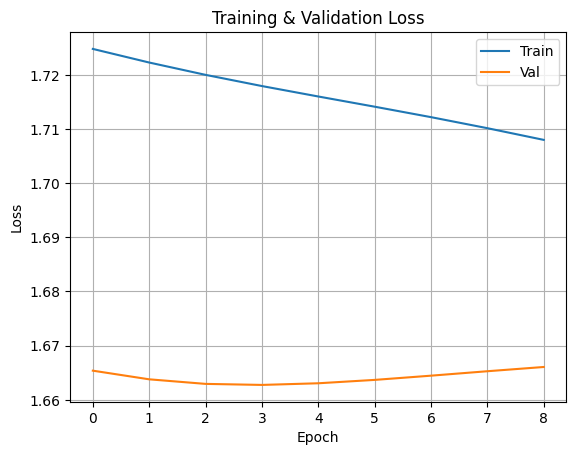

Testing: 100%|██████████| 1/1 [00:00<00:00, 318.89it/s]


Classification Report:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.33      1.00      0.50         1
      digestive system diseases       0.00      0.00      0.00         1
general pathological conditions       0.00      0.00      0.00         1
                      neoplasms       0.00      0.00      0.00         1
        nervous system diseases       0.00      0.00      0.00         1

                       accuracy                           0.20         5
                      macro avg       0.07      0.20      0.10         5
                   weighted avg       0.07      0.20      0.10         5




/Users/dauduchieu/Documents/iSE2025/CBM/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dauduchieu/Documents/iSE2025/CBM/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dauduchieu/Documents/iSE2025/CBM/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [ ]:
from sentence_transformers import SentenceTransformer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# SBERT embedding
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_kw = sbert_model.encode(keywords)
sbert_abs = sbert_model.encode(abstract_concepts)
sbert_lbl = sbert_model.encode(labels)

# Train
concept_names = [keywords, abstract_concepts, labels]
model = ConceptNetwork(concept_names, embedding_dim=64)
train_model(
    model, train_keyword_scores, train_abstract_scores, train_labels,
    val_keyword_scores, val_abstract_scores, val_labels,
    concept_names, [sbert_kw, sbert_abs, sbert_lbl]
)

# Evaluate
evaluate_model(model, test_keyword_scores, test_abstract_scores, test_labels, labels)
